In [1]:
from shapely import from_wkt
import polars as pl
from polars import col as c
from shapely.geometry import Point, Polygon, MultiPolygon, MultiLineString
from shapely import set_precision, extract_unique_points
from shapely_function import segment_list_from_multilinestring, shape_list_to_wkt_list, multipoint_from_multilinestring
from polars_shapely_function import get_linestring_boundaries_col, get_multigeometry_from_col, shape_intersect_shape_col
from shapely.geometry import LineString, MultiLineString, MultiPoint
from networkx_function import generate_nx_edge, highlight_connected_edges
import networkx as nx

In [ ]:
from shapely.ops import nearest_points


linestrings_str = [
    LineString([(0, 0), (1, 1), (2, 2)]),
    LineString([(2, 3), (4, 4), (5, 5)]),
    LineString([(2, 3), (7, 7), (8, 8)]),
    LineString([(9, 9), (10, 10), (11, 11)]),
    LineString([(12, 52), (13, 13), (14, 14)]),
    LineString([(15, 15), (12, 52), (17, 17)]),
    LineString([(18, 18), (19, 19), (20, 20)]),
    LineString([(21, 21), (27, 22), (23, 23)]),
    LineString([(24, 24), (25, 25), (26, 26)]),
    LineString([(27, 27), (28, 28), (27, 22)])
]

def generate_and_connect_segment_from_linestring_list(linestring_list: list[LineString]) -> list[LineString]:

    segment_list: list[LineString] = segment_list_from_multilinestring(MultiLineString(linestring_list))

    segment_pl: pl.DataFrame  = pl.DataFrame({
        "geometry" : shape_list_to_wkt_list(segment_list) # type: ignore
        }).with_columns(
            c("geometry").pipe(get_linestring_boundaries_col).alias("node_id"),
            c("geometry").pipe(get_linestring_boundaries_col).alias("edge_id")
            .list.to_struct(fields=["v_of_edge", "u_of_edge"])
        ).unnest("edge_id")
        
    nx_graph = nx.Graph()
    _ = segment_pl.with_columns(
            pl.struct("v_of_edge", "u_of_edge", "geometry").pipe(generate_nx_edge, nx_graph= nx_graph)
        )  

    if nx.is_connected(nx_graph):
        return segment_list  

    connected_edge: pl.DataFrame = highlight_connected_edges(nx_graph=nx_graph)

    graph_connected: list[int] = []
    for graph_id in connected_edge["graph_id"].unique():
        if graph_id not in graph_connected:
            if graph_connected:
                graph_id_to_check: list[int] = graph_connected
            else:
                graph_id_to_check: list[int] = connected_edge.filter(c("graph_id") != graph_id)["graph_id"].unique().to_list()
                
            point_to_connect: MultiPoint = multipoint_from_multilinestring(
                get_multigeometry_from_col(connected_edge.filter(c("graph_id") == graph_id))) # type: ignore
            point_to_check: MultiPoint = multipoint_from_multilinestring(
                get_multigeometry_from_col(connected_edge.filter(c("graph_id").is_in(graph_id_to_check))) # type: ignore
            )

            new_segment_points = nearest_points(point_to_connect, point_to_check)
                
            graph_connected.extend(
                connected_edge
                .filter(c("geometry").pipe(shape_intersect_shape_col, geometry=MultiPoint(new_segment_points)))
                ["graph_id"].unique().to_list()
            )
            segment_list.append(LineString(new_segment_points))
    return segment_list


In [12]:
segment_list

[<LINESTRING (0 0, 1 1)>,
 <LINESTRING (1 1, 2 2)>,
 <LINESTRING (2 3, 4 4)>,
 <LINESTRING (4 4, 5 5)>,
 <LINESTRING (2 3, 7 7)>,
 <LINESTRING (7 7, 8 8)>,
 <LINESTRING (9 9, 10 10)>,
 <LINESTRING (10 10, 11 11)>,
 <LINESTRING (12 52, 13 13)>,
 <LINESTRING (13 13, 14 14)>,
 <LINESTRING (15 15, 12 52)>,
 <LINESTRING (12 52, 17 17)>,
 <LINESTRING (18 18, 19 19)>,
 <LINESTRING (19 19, 20 20)>,
 <LINESTRING (21 21, 27 22)>,
 <LINESTRING (27 22, 23 23)>,
 <LINESTRING (24 24, 25 25)>,
 <LINESTRING (25 25, 26 26)>,
 <LINESTRING (27 27, 28 28)>,
 <LINESTRING (28 28, 27 22)>,
 <LINESTRING (2 2, 2 3)>,
 <LINESTRING (9 9, 8 8)>,
 <LINESTRING (13 13, 11 11)>,
 <LINESTRING (18 18, 17 17)>,
 <LINESTRING (21 21, 20 20)>,
 <LINESTRING (24 24, 23 23)>]

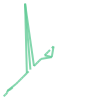

In [11]:
MultiLineString(segment_list)

0
1
2
3
4
5
6


In [9]:
segment_list

[<LINESTRING (0 0, 1 1)>,
 <LINESTRING (1 1, 2 2)>,
 <LINESTRING (2 3, 4 4)>,
 <LINESTRING (4 4, 5 5)>,
 <LINESTRING (2 3, 7 7)>,
 <LINESTRING (7 7, 8 8)>,
 <LINESTRING (9 9, 10 10)>,
 <LINESTRING (10 10, 11 11)>,
 <LINESTRING (12 52, 13 13)>,
 <LINESTRING (13 13, 14 14)>,
 <LINESTRING (15 15, 12 52)>,
 <LINESTRING (12 52, 17 17)>,
 <LINESTRING (18 18, 19 19)>,
 <LINESTRING (19 19, 20 20)>,
 <LINESTRING (21 21, 27 22)>,
 <LINESTRING (27 22, 23 23)>,
 <LINESTRING (24 24, 25 25)>,
 <LINESTRING (25 25, 26 26)>,
 <LINESTRING (27 27, 28 28)>,
 <LINESTRING (28 28, 27 22)>]

In [8]:
new_segments

[<LINESTRING (2 2, 2 3)>,
 <LINESTRING (9 9, 8 8)>,
 <LINESTRING (13 13, 11 11)>,
 <LINESTRING (18 18, 17 17)>,
 <LINESTRING (21 21, 20 20)>,
 <LINESTRING (24 24, 23 23)>]

In [ ]:
new_segment

In [4]:
highlight_connected_edges(nx_graph)

graph_id,u_of_edge,v_of_edge,geometry
i64,str,str,str
0,"""POINT (1 1)""","""POINT (0 0)""","""LINESTRING (0 0, 1 1)"""
0,"""POINT (1 1)""","""POINT (2 2)""","""LINESTRING (1 1, 2 2)"""
1,"""POINT (5 5)""","""POINT (4 4)""","""LINESTRING (4 4, 5 5)"""
1,"""POINT (7 7)""","""POINT (2 3)""","""LINESTRING (2 3, 7 7)"""
1,"""POINT (7 7)""","""POINT (8 8)""","""LINESTRING (7 7, 8 8)"""
…,…,…,…
5,"""POINT (28 28)""","""POINT (27 22)""","""LINESTRING (28 28, 27 22)"""
5,"""POINT (27 22)""","""POINT (21 21)""","""LINESTRING (21 21, 27 22)"""
5,"""POINT (27 22)""","""POINT (23 23)""","""LINESTRING (27 22, 23 23)"""


In [5]:

# Generate a list of lists of points
points = pl.DataFrame({"geo": [[(Point(x, y)).wkt for x in range(3)] for y in range(3)]})

points.select(
    c("geo").list.eval(pl.element().map_elements(from_wkt, return_dtype=pl.Object))
)

thread '<unnamed>' panicked at crates/polars-core/src/series/iterator.rs:84:9:
object dtype not supported in Series.iter
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: object dtype not supported in Series.iter